# Training and Deploying a Prediction model for Real-time Inference

## Learning objectives

1. Use Python & SQL to query the public data in BigQuery.
2. Prepare the data for modeling.
3. Train a classification model using BigQuery ML.
4. Inspect the model on Vertex AI Model Registry.
5. Deploy the model to an endpoint.
6. Make online predictions to the endpoint.

## Overview

This notebook is aimed at data analysts and data scientists who have data in BigQuery, want to train a model using BigQuery ML, register the model to Vertex AI Model Registry, and deploy it to an endpoint for real-time prediction. 

In this notebook, you will learn how to train and deploy a churn prediction model for real-time inference, with the data in BigQuery and model trained using BigQuery ML, registered to Vertex AI Model Registry, and deployed to an endpoint on Vertex AI for online predictions.

### Dataset

The dataset, <a href="https://console.cloud.google.com/bigquery?project=bigquery-public-data&d=ga4_obfuscated_sample_ecommerce&p=bigquery-public-data&page=dataset" target="_blank">available publicly on BigQuery</a>, comes from obfuscated <a href="https://support.google.com/analytics/answer/10937659" target="_blank">Google Analytics 4 data</a> from the <a href="https://shop.googlemerchandisestore.com/" target="_blank">Google Merchandise Store</a>).

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/bqml-online-prediction.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

### Install additional packages

Install the following packages required to execute this notebook. 

In [1]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

! pip3 install --upgrade google-cloud-aiplatform {USER_FLAG} -q google-cloud-bigquery db-dtypes

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-recommendations-ai 0.2.0 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you have google-api-core 2.8.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 9.0.0 which is incompatible.


### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [2]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [1]:
PROJECT_ID = "[your-project-id]" # Replace with your Project ID

# Get your Google Cloud project ID from gcloud
import os

if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  qwiklabs-gcp-04-146a9155ea7b


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You might not be able to use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about <a href="https://cloud.google.com/vertex-ai/docs/general/locations" target="_blank">Vertex AI regions</a>.

In [2]:
REGION = "[your-region]"  # Replace with your region

if REGION == "[your-region]":
    REGION = "us-central1"

#### UUID

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a uuid for each instance session, and append it onto the name of resources you create in this tutorial.

In [3]:
import random
import string


# Generate a uuid of a specifed length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


UUID = generate_uuid()

### Import libraries

In [4]:
from typing import Union

import google.cloud.aiplatform as vertex_ai
import pandas as pd
from google.cloud import bigquery

### Initialize Vertex AI and BigQuery SDKs for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [5]:
vertex_ai.init(project=PROJECT_ID, location=REGION)

Create the BigQuery client.

In [6]:
# TODO 1
# Create the BigQuery client w.r.t your Project ID
bq_client = bigquery.Client(project=PROJECT_ID)

Use a helper function for sending queries to BigQuery.

In [7]:
# Wrapper to use BigQuery client to run query/job, return job ID or result as DF
def run_bq_query(sql: str) -> Union[str, pd.DataFrame]:
    """
    Input: SQL query, as a string, to execute in BigQuery
    Returns the query results as a pandas DataFrame, or error, if any
    """

    # Try dry run before executing query to catch any errors
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    bq_client.query(sql, job_config=job_config)

    # If dry run succeeds without errors, proceed to run query
    job_config = bigquery.QueryJobConfig()
    client_result = bq_client.query(sql, job_config=job_config)

    job_id = client_result.job_id

    # Wait for query/job to finish running. then get & return data frame
    df = client_result.result().to_arrow().to_pandas()
    print(f"Finished job_id: {job_id}")
    return df

## BigQuery ML introduction

BigQuery ML (BQML) provides the capability to train ML tabular models, such as classification, regression, forecasting, and matrix factorization, in BigQuery using SQL syntax directly. BigQuery ML uses the scalable infrastructure of BigQuery ML so you don't need to set up additional infrastructure for training or batch serving.

Learn more about <a href="https://cloud.google.com/bigquery-ml/docs" target="_blank">BigQuery ML documentation</a>.

In [8]:
BQ_DATASET_NAME = f"ga4_churnprediction_{UUID}"

sql_create_dataset = f"""CREATE SCHEMA IF NOT EXISTS {BQ_DATASET_NAME}"""

print(sql_create_dataset)

run_bq_query(sql_create_dataset)

CREATE SCHEMA IF NOT EXISTS ga4_churnprediction_9amu5eqp
Finished job_id: 46d9018a-2b98-4427-b7e8-f46a00783d62


""


### Inspect the pre-processed Google Analytics 4 data

Inpect data that has been pre-processed from <a href="https://support.google.com/analytics/answer/10937659" target="_blank">Google Analytics 4 data from the Google Merchandise Store</a> so that it can be used for classification. For more information on how this data was prepared, read <a href="https://cloud.google.com/blog/topics/developers-practitioners/churn-prediction-game-developers-using-google-analytics-4-ga4-and-bigquery-ml" target="_blank">this blog post</a>.

As seen below, each row represents a single user, and the columns represent their demographic features, their aggregated behavioral features in the first 24 hours of visiting the Google Merchandise Store, and the label (whether the user churned or returned any time after the first 24 hours).

In [9]:
sql_inspect = """
SELECT
    *
FROM
    `bqmlpublic.demo_ga4churnprediction.training_data`
LIMIT
    100
"""
run_bq_query(sql_inspect)

Finished job_id: c0fbd61a-9da5-46a1-bc7a-51b3f7901fde


,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_page_view,cnt_view_item,cnt_view_promotion,cnt_select_promotion,cnt_add_to_cart,cnt_begin_checkout,cnt_add_shipping_info,cnt_add_payment_info,cnt_purchase,user_first_engagement,month,julianday,dayofweek,churned
0,7666337.2408476627,United States,Web,en-us,5,6,2,0,0,0,0,0,0,0,2021-01-01 19:23:47.339545+00:00,1,1,6,1
1,44740556.1615757380,Canada,Macintosh,None,6,7,2,0,0,0,0,0,0,0,2021-01-01 11:42:53.072756+00:00,1,1,6,1
2,91028872.0097105946,United States,Windows,en-us,2,3,0,1,0,0,0,0,0,0,2021-01-01 19:07:53.669542+00:00,1,1,6,1
3,63655374.9348413503,United States,Web,es-es,8,10,6,3,0,0,0,0,0,0,2021-01-01 12:03:29.281546+00:00,1,1,6,0
4,10115718.4867090359,United States,Web,None,15,12,9,0,0,0,0,0,0,0,2021-01-01 18:32:29.296973+00:00,1,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2304235.4728947355,United States,Web,en-us,1,2,0,0,0,0,0,0,0,0,2021-01-01 16:39:41.910818+00:00,1,1,6,0
96,4902634.1944567521,Germany,Web,en-us,1,3,0,1,0,0,0,0,0,0,2021-01-01 12:08:53.020090+00:00,1,1,6,0
97,6385315.9680167296,Russia,Web,en-us,2,5,1,2,1,0,0,0,0,0,2021-01-01 11:08:32.462414+00:00,1,1,6,1
98,36665674.3318230125,Spain,<Other>,en-us,2,4,0,0,0,0,0,0,0,0,2021-01-01 03:06:33.897251+00:00,1,1,6,1


### Train a classification model using BigQuery ML

The query below trains a logistic regression model using BigQuery ML. BigQuery resources are used to train the model.

In the `OPTIONS` parameter:
* with `model_registry="vertex_ai"`, the BigQuery ML model will automatically be <a href="https://cloud.google.com/vertex-ai/docs/model-registry/model-registry-bqml" target="_blank">registered to Vertex AI Model Registry</a>, which enables you to view all of your registered models and its versions on Google Cloud in one place.

* `vertex_ai_model_version_aliases allows you to set aliases to help you keep track of your model version (<a href="https://cloud.google.com/vertex-ai/docs/model-registry/model-alias" target="_blank">documentation</a>).

In [10]:
# TODO 2
# this cell may take ~1 min to run
# Create a classification model

BQML_MODEL_NAME = f"bqml_model_churn_{UUID}"

sql_train_model_bqml = f"""
CREATE OR REPLACE MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME}    
OPTIONS(
  MODEL_TYPE="LOGISTIC_REG",
  input_label_cols=["churned"],
  model_registry="vertex_ai",
  vertex_ai_model_version_aliases=['logistic_reg', 'experimental']
) AS

SELECT
  * EXCEPT(user_first_engagement, user_pseudo_id)
FROM
  bqmlpublic.demo_ga4churnprediction.training_data
"""

print(sql_train_model_bqml)

run_bq_query(sql_train_model_bqml)


CREATE OR REPLACE MODEL ga4_churnprediction_9amu5eqp.bqml_model_churn_9amu5eqp    
OPTIONS(
  MODEL_TYPE="LOGISTIC_REG",
  input_label_cols=["churned"],
  model_registry="vertex_ai",
  vertex_ai_model_version_aliases=['logistic_reg', 'experimental']
) AS

SELECT
  * EXCEPT(user_first_engagement, user_pseudo_id)
FROM
  bqmlpublic.demo_ga4churnprediction.training_data

Finished job_id: 89999ef7-8688-49c1-9ebf-3752369914b5


""


### Model evaluation

With the model created, you can now evaluate the logistic regression model. Behind the scenes, BigQuery ML automatically <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#data_split_method" target="_blank">split the data</a>, which makes it easier to quickly train and evaluate models.

In [11]:
sql_evaluate_model = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME})
"""

print(sql_evaluate_model)

run_bq_query(sql_evaluate_model)


SELECT
  *
FROM
  ML.EVALUATE(MODEL ga4_churnprediction_9amu5eqp.bqml_model_churn_9amu5eqp)

Finished job_id: 908795b4-8b83-4183-a5bf-d5e967ce4a98


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.571924,0.995775,0.571083,0.726552,0.671342,0.602277


These metrics help you understand the performance of the model. 

There are various metrics for logistic regression and other model types (full list of metrics can be found in the <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate#mlevaluate_output" target="_blank">documentation</a>).

### Batch prediction (with Explainable AI)

Make a batch prediction in BigQuery ML on the original training data to check the probability of churn for each of the users, as seen in the `probability` column, with the predicted label under the `predicted_churn` column.

<a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict" target="_blank">ML.EXPLAIN_PREDICT</a> has built-in <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview" target="_blank">Explainable AI</a>. This allows you to see the top contributing features to each prediction and interpret how it was computed.

In [12]:
sql_explain_predict = f"""
SELECT
  *
FROM
  ML.EXPLAIN_PREDICT(MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME},
    (SELECT * FROM bqmlpublic.demo_ga4churnprediction.training_data LIMIT 100)
    )
"""

print(sql_explain_predict)

run_bq_query(sql_explain_predict)


SELECT
  *
FROM
  ML.EXPLAIN_PREDICT(MODEL ga4_churnprediction_9amu5eqp.bqml_model_churn_9amu5eqp,
    (SELECT * FROM bqmlpublic.demo_ga4churnprediction.training_data LIMIT 100)
    )

Finished job_id: 1007d132-d8f5-47e3-8a4f-3f5da72a383d


,predicted_churned,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,user_pseudo_id,country,operating_system,language,...,cnt_add_to_cart,cnt_begin_checkout,cnt_add_shipping_info,cnt_add_payment_info,cnt_purchase,user_first_engagement,month,julianday,dayofweek,churned
0,1,0.590461,"[{'feature': 'language', 'attribution': 0.0975...",0.069157,0.365871,0.0,7666337.2408476627,United States,Web,en-us,...,0,0,0,0,0,2021-01-01 19:23:47.339545+00:00,1,1,6,1
1,1,0.564491,"[{'feature': 'month', 'attribution': 0.0808542...",0.069157,0.259407,0.0,44740556.1615757380,Canada,Macintosh,None,...,0,0,0,0,0,2021-01-01 11:42:53.072756+00:00,1,1,6,1
2,1,0.591651,"[{'feature': 'language', 'attribution': 0.0975...",0.069157,0.370796,0.0,91028872.0097105946,United States,Windows,en-us,...,0,0,0,0,0,2021-01-01 19:07:53.669542+00:00,1,1,6,1
3,1,0.612900,"[{'feature': 'month', 'attribution': 0.0808542...",0.069157,0.459517,0.0,63655374.9348413503,United States,Web,es-es,...,0,0,0,0,0,2021-01-01 12:03:29.281546+00:00,1,1,6,0
4,1,0.595990,"[{'feature': 'month', 'attribution': 0.0808542...",0.069157,0.388785,0.0,10115718.4867090359,United States,Web,None,...,0,0,0,0,0,2021-01-01 18:32:29.296973+00:00,1,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0.582265,"[{'feature': 'language', 'attribution': 0.0975...",0.069157,0.332077,0.0,2304235.4728947355,United States,Web,en-us,...,0,0,0,0,0,2021-01-01 16:39:41.910818+00:00,1,1,6,0
96,1,0.595478,"[{'feature': 'country', 'attribution': 0.09822...",0.069157,0.386659,0.0,4902634.1944567521,Germany,Web,en-us,...,0,0,0,0,0,2021-01-01 12:08:53.020090+00:00,1,1,6,0
97,1,0.594728,"[{'feature': 'language', 'attribution': 0.0975...",0.069157,0.383546,0.0,6385315.9680167296,Russia,Web,en-us,...,0,0,0,0,0,2021-01-01 11:08:32.462414+00:00,1,1,6,1
98,1,0.578454,"[{'feature': 'language', 'attribution': 0.0975...",0.069157,0.316432,0.0,36665674.3318230125,Spain,<Other>,en-us,...,0,0,0,0,0,2021-01-01 03:06:33.897251+00:00,1,1,6,1


Since the `top_feature_attributions` is a nested column, you can unnest the array (<a href="https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays" target="_blank">documentation</a>) into separate rows for each of the features. In other words, since ML.EXPLAIN_PREDICT provides the top 5 most important features, using `UNNEST` results in 5 rows per prediction:

In [13]:
sql_explain_predict = f"""
SELECT
  tfa.*,
  predicted_churned,
  probability,
  baseline_prediction_value,
  prediction_value,
  approximation_error,
  user_pseudo_id
FROM
  ML.EXPLAIN_PREDICT(MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME},
    (SELECT * FROM bqmlpublic.demo_ga4churnprediction.training_data LIMIT 100)
    ),
  UNNEST(top_feature_attributions) as tfa
WHERE
  user_pseudo_id = "7666337.2408476627"
"""

print(sql_explain_predict)

run_bq_query(sql_explain_predict)


SELECT
  tfa.*,
  predicted_churned,
  probability,
  baseline_prediction_value,
  prediction_value,
  approximation_error,
  user_pseudo_id
FROM
  ML.EXPLAIN_PREDICT(MODEL ga4_churnprediction_9amu5eqp.bqml_model_churn_9amu5eqp,
    (SELECT * FROM bqmlpublic.demo_ga4churnprediction.training_data LIMIT 100)
    ),
  UNNEST(top_feature_attributions) as tfa
WHERE
  user_pseudo_id = "7666337.2408476627"

Finished job_id: ecc6b6a6-c042-43c0-afee-ef2a92048902


,feature,attribution,predicted_churned,probability,baseline_prediction_value,prediction_value,approximation_error,user_pseudo_id
0,language,0.097598,1,0.590461,0.069157,0.365871,0.0,7666337.2408476627
1,month,0.080854,1,0.590461,0.069157,0.365871,0.0,7666337.2408476627
2,julianday,0.080515,1,0.590461,0.069157,0.365871,0.0,7666337.2408476627
3,operating_system,0.075108,1,0.590461,0.069157,0.365871,0.0,7666337.2408476627
4,country,0.074942,1,0.590461,0.069157,0.365871,0.0,7666337.2408476627


### Inspect the model on Vertex AI Model Registry

When the model was trained in BigQuery ML, the line `model_registry="vertex_ai"` registered the model to Vertex AI Model Registry automatically upon completion.

You can view the model on the <a href="https://console.cloud.google.com/vertex-ai/models" target="_blank">Vertex AI Model Registry page</a>:

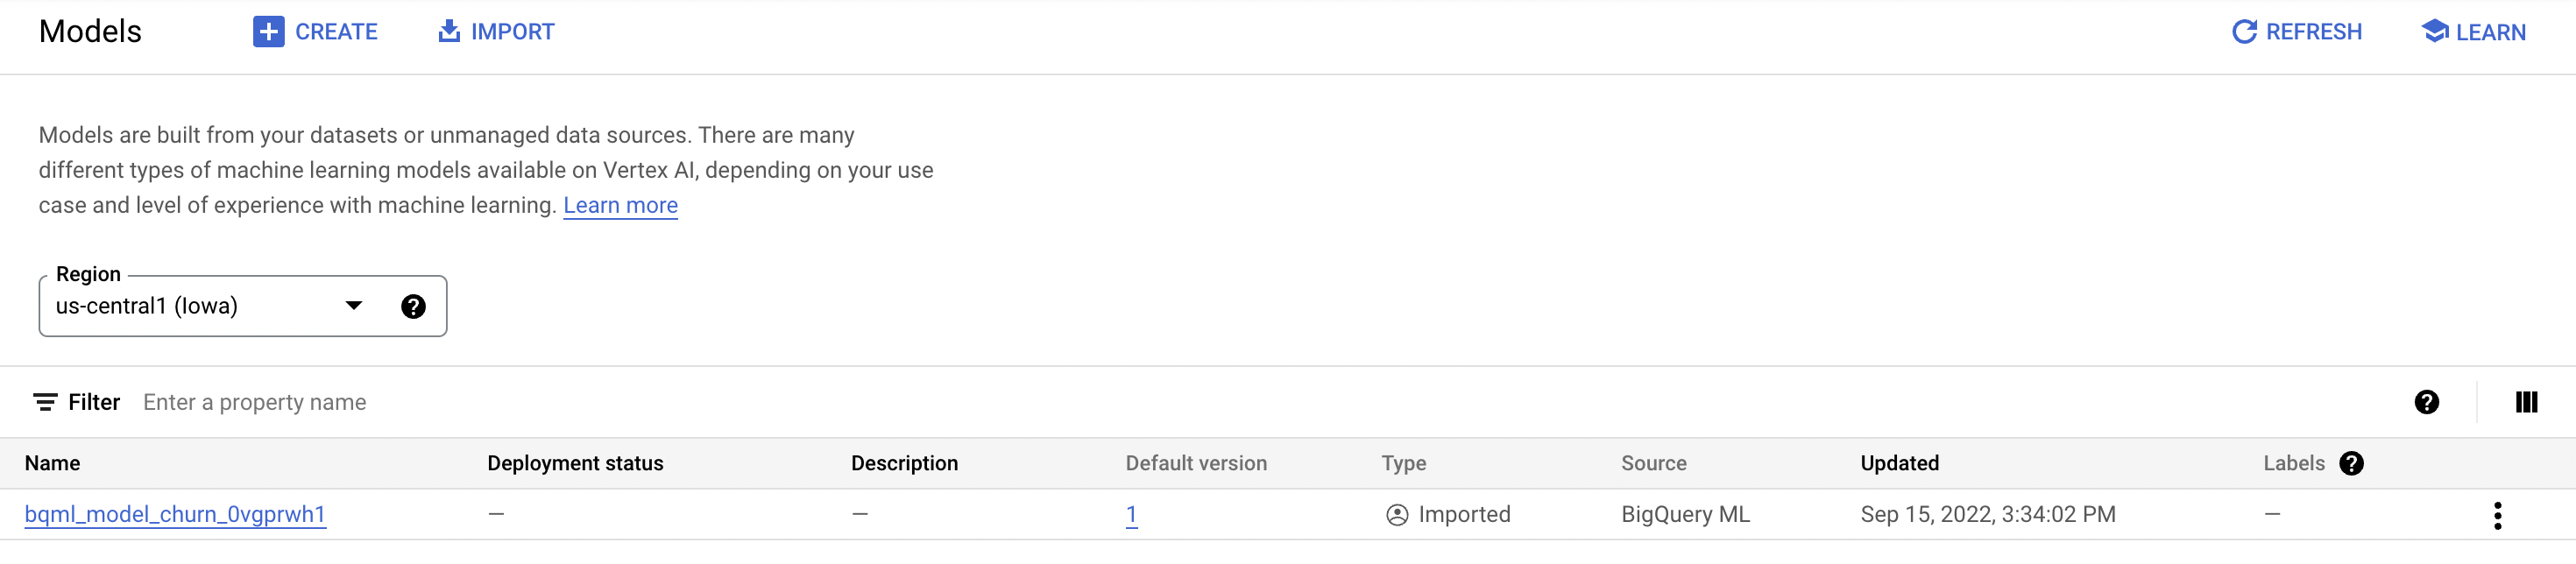

Or use the code below to check that it was successfully registered:

In [14]:
model = vertex_ai.Model(model_name=BQML_MODEL_NAME)

print(model.gca_resource)

name: "projects/233098494272/locations/us-central1/models/bqml_model_churn_9amu5eqp"
display_name: "bqml_model_churn_9amu5eqp"
supported_deployment_resources_types: DEDICATED_RESOURCES
create_time {
  seconds: 1662981296
  nanos: 754027000
}
update_time {
  seconds: 1662981320
  nanos: 179210000
}
etag: "AMEw9yP80B8hGpRh4qoev0Z8qSdPdnlnDBwyGLE426vMfFFCNOKJjHutCCLZtZJz-Kw="
version_id: "1"
version_aliases: "logistic_reg"
version_aliases: "experimental"
version_aliases: "default"
version_create_time {
  seconds: 1662981296
  nanos: 754027000
}
version_update_time {
  seconds: 1662981320
  nanos: 148137000
}



### Deploy the model to an endpoint

While BigQuery ML supports batch prediction with <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict" target="_blank">ML.PREDICT</a> and <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict" target="_blank">ML.EXPLAIN_PREDICT</a>, BigQuery ML is not suitable for real-time predictions where you need low latency predictions with potentially high frequency of requests.

In other words, deploying the BigQuery ML model to an endpoint enables you to do online predictions.

#### Create a Vertex AI endpoint

To deploy your model to an endpoint, you will first need to create an endpoint before you deploy the model to it.

In [15]:
# TODO 3
ENDPOINT_NAME = f"{BQML_MODEL_NAME}-endpoint"

# Create a Vertex AI endpoint
endpoint = vertex_ai.Endpoint.create(
    display_name=ENDPOINT_NAME,
    project=PROJECT_ID,
    location=REGION,
)

print(endpoint.display_name)
print(endpoint.resource_name)

Creating Endpoint
Create Endpoint backing LRO: projects/233098494272/locations/us-central1/endpoints/7731827339171987456/operations/4227433436396126208
Endpoint created. Resource name: projects/233098494272/locations/us-central1/endpoints/7731827339171987456
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/233098494272/locations/us-central1/endpoints/7731827339171987456')
bqml_model_churn_9amu5eqp-endpoint
projects/233098494272/locations/us-central1/endpoints/7731827339171987456


You can view your endpoints on the <a href="https://console.cloud.google.com/vertex-ai/endpoints" target="_blank">Vertex AI Endpoints page</a>:

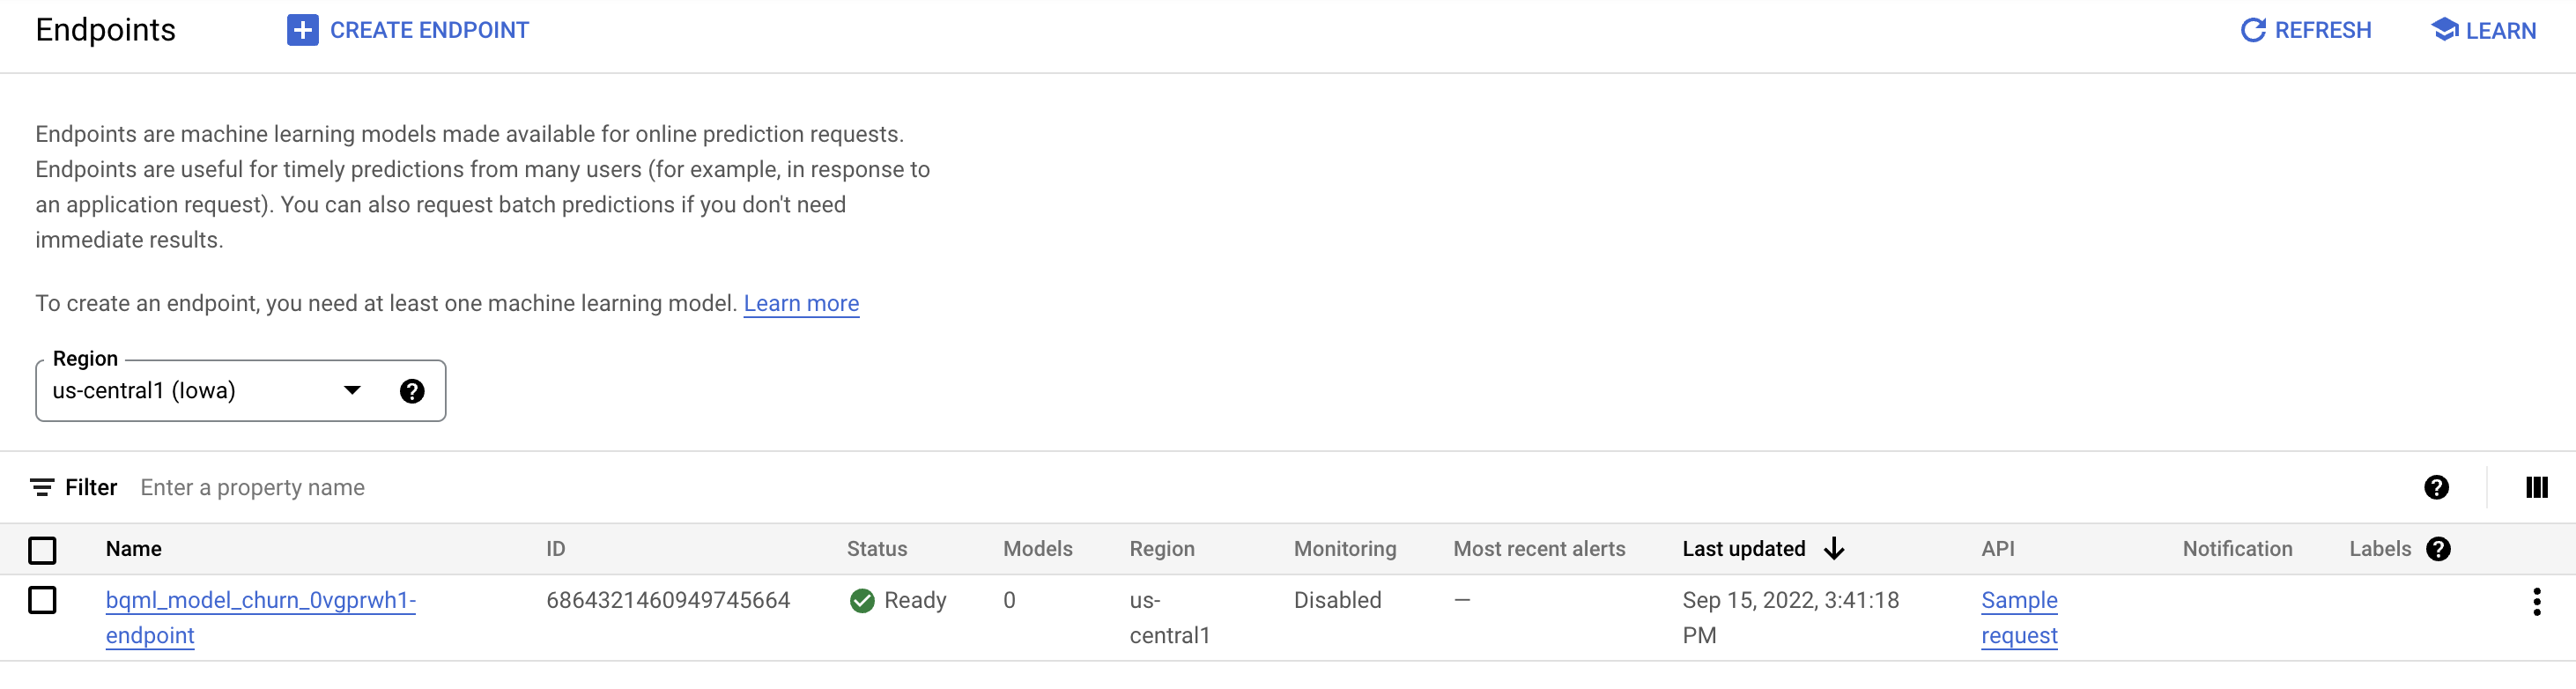

#### List endpoints

List the endpoints to make sure it has successfully been created.

In [16]:
endpoint.list()

 resource name: projects/233098494272/locations/us-central1/endpoints/7731827339171987456]

#### Deploy model to Vertex endpoint

With the new endpoint, you can now deploy your model.

In [17]:
# TODO 4
# Deploy your model to the endpoint
# deploying the model to the endpoint may take 10-15 minutes
model.deploy(endpoint=endpoint)

Deploying model to Endpoint : projects/233098494272/locations/us-central1/endpoints/7731827339171987456
Using default machine_type: n1-standard-2
Deploy Endpoint model backing LRO: projects/233098494272/locations/us-central1/endpoints/7731827339171987456/operations/1073787797329936384
Endpoint model deployed. Resource name: projects/233098494272/locations/us-central1/endpoints/7731827339171987456


resource name: projects/233098494272/locations/us-central1/endpoints/7731827339171987456

You can also check on the status of your model by visiting the <a href="https://console.cloud.google.com/vertex-ai/endpoints" target="_blank">Vertex AI Endpoints page</a>.

### Make online predictions to the endpoint

Using a sample of the training data, you can test the endpoint to make online predictions.

In [18]:
df_sample_requests_list = [
    {
        "country": "Turkey",
        "operating_system": "Web",
        "language": "None",
        "cnt_user_engagement": 28,
        "cnt_page_view": 37,
        "cnt_view_item": 6,
        "cnt_view_promotion": 15,
        "cnt_select_promotion": 4,
        "cnt_add_to_cart": 0,
        "cnt_begin_checkout": 0,
        "cnt_add_shipping_info": 0,
        "cnt_add_payment_info": 0,
        "cnt_purchase": 0,
        "month": 1,
        "julianday": 1,
        "dayofweek": 6,
    },
    {
        "country": "Macao",
        "operating_system": "Web",
        "language": "None",
        "cnt_user_engagement": 2,
        "cnt_page_view": 4,
        "cnt_view_item": 0,
        "cnt_view_promotion": 0,
        "cnt_select_promotion": 0,
        "cnt_add_to_cart": 0,
        "cnt_begin_checkout": 0,
        "cnt_add_shipping_info": 0,
        "cnt_add_payment_info": 0,
        "cnt_purchase": 0,
        "month": 1,
        "julianday": 16,
        "dayofweek": 7,
    },
]

In [19]:
# TODO 5
# Make the prediction to the endpoint
prediction = endpoint.predict(df_sample_requests_list)
print(prediction)

Prediction(predictions=[{'churned_values': ['1', '0'], 'churned_probs': [0.7541578275932675, 0.2458421724067325], 'predicted_churned': ['1']}, {'churned_values': ['1', '0'], 'churned_probs': [0.4827901063200363, 0.5172098936799636], 'predicted_churned': ['0']}], deployed_model_id='9057746003293110272', model_version_id='1', model_resource_name='projects/233098494272/locations/us-central1/models/bqml_model_churn_9amu5eqp', explanations=None)


You can then extract the predictions from the prediction response

In [20]:
prediction.predictions

[{'churned_values': ['1', '0'],
  'churned_probs': [0.7541578275932675, 0.2458421724067325],
  'predicted_churned': ['1']},
 {'churned_values': ['1', '0'],
  'churned_probs': [0.4827901063200363, 0.5172098936799636],
  'predicted_churned': ['0']}]

## Cleaning up

To clean up all Google Cloud resources used in this project, you can <a href="https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects" target="_blank">delete the Google Cloud
project</a> you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [21]:
# Undeploy model from endpoint and delete endpoint
endpoint.undeploy_all()
endpoint.delete()

# Delete BigQuery dataset, including the BigQuery ML model
! bq rm -r -f $PROJECT_ID:$BQ_DATASET_NAME

Undeploying Endpoint model: projects/233098494272/locations/us-central1/endpoints/7731827339171987456
Undeploy Endpoint model backing LRO: projects/233098494272/locations/us-central1/endpoints/7731827339171987456/operations/6332866262191833088
Endpoint model undeployed. Resource name: projects/233098494272/locations/us-central1/endpoints/7731827339171987456
Deleting Endpoint : projects/233098494272/locations/us-central1/endpoints/7731827339171987456
Delete Endpoint  backing LRO: projects/233098494272/locations/us-central1/operations/3785517722960396288
Endpoint deleted. . Resource name: projects/233098494272/locations/us-central1/endpoints/7731827339171987456
